In [16]:
# загрузка пакетов: инструменты -------------------------------------------- # работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
# тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
# для таймера
import time
# загрузка пакетов: модели ------------------------------------------------- # линейные модели
import sklearn.linear_model as skl_lm
# расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score

In [23]:
# Загрузка констант и глобальных настроек
Train_frac = 0.8
K_VAL = 10
Alpha = 0.05
# ядро для генератора случайных чисел
my_seed = 11
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html mpl.style.use('seaborn-whitegrid')
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")

In [18]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/Boston_for_lab.csv'

DF_raw = pd.read_csv(fileURL)
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (506, 15)


In [19]:
# количество пропусков
DF_raw.isna().sum()

crim            0
zn              0
indus           0
chas            0
nox             0
rm              0
age             0
dis             0
rad             0
tax             0
ptratio         0
black           0
lstat           0
medv            0
tax_over_400    0
dtype: int64

Пропусков в столбцах отсутствуют.

In [20]:
# типы столбцов фрейма
DF_raw.dtypes

crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rm              float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
black           float64
lstat           float64
medv            float64
tax_over_400      int64
dtype: object

Все столбцы таблицы имеют численное значение.

In [22]:
DF_all = DF_all[['medv', 'crim', 'indus', 'tax_over_400']]
DF_all 

,medv,crim,indus,tax_over_400
0,24.0,0.00632,2.31,0
1,21.6,0.02731,7.07,0
2,34.7,0.02729,7.07,0
3,33.4,0.03237,2.18,0
4,36.2,0.06905,2.18,0
...,...,...,...,...
501,22.4,0.06263,11.93,0
502,20.6,0.04527,11.93,0
503,23.9,0.06076,11.93,0
504,22.0,0.10959,11.93,0


In [24]:
# данные для построения моделей
DF = DF_all.sample(frac = Train_frac, random_state = my_seed)
# данные для прогнозов
DF_predict = DF_all.drop(DF.index)
del DF_raw

### Предварительный анализ данных 

In [25]:
DF[['medv', 'crim', 'indus']].describe()

,medv,crim,indus
count,405.000000,405.000000,405.000000
mean,22.418272,3.694793,11.266938
std,9.271841,8.335096,6.937377
min,5.000000,0.006320,0.460000
25%,16.600000,0.083700,5.130000
50%,21.200000,0.269380,9.900000
75%,25.000000,3.774980,18.100000
max,50.000000,73.534100,27.740000


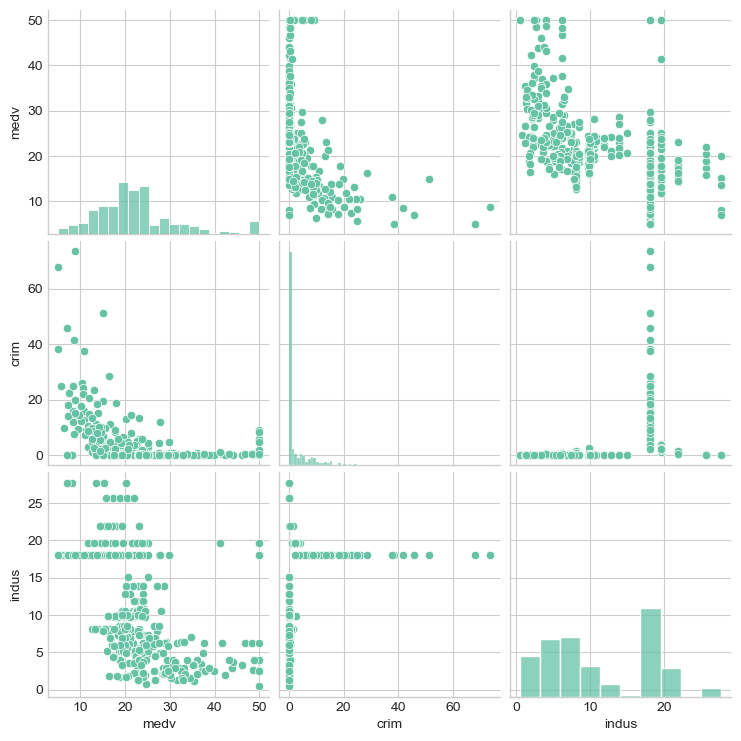

In [26]:
sns.pairplot(DF[['medv', 'crim', 'indus']])
plt.show()

По графикам видно, что распределения переменных отличны от нормального.

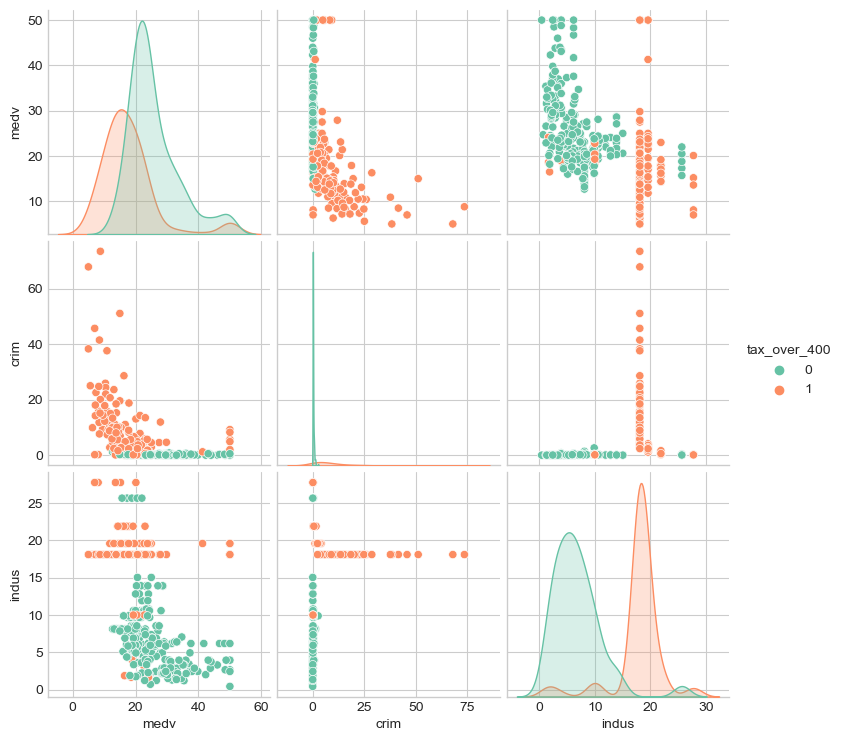

In [27]:
sns.pairplot(DF[['medv', 'crim', 'indus','tax_over_400']], hue='tax_over_400')
plt.show()

Можно предположить, что при превышении 400 полной ставки налога на имущество 1000$ медианная стоимость домов падает.

In [28]:
#Посмотрим на корреляционные матрицы переменных фрейма.
corr_mat = DF[['medv', 'crim', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,medv,crim,indus
medv,1.000000,-0.416527,-0.496836
crim,-0.416527,1.000000,0.416992
indus,-0.496836,0.416992,1.000000


Максимальная теснота линейной взаимосвязи соответствует коэффицтенту корреляции между medv и indus. Коэффициент равен -0.497, без разбиения на классы наблюдений по фиктивным переменным.

In [30]:
corr_mat = DF.loc[DF['tax_over_400'] == 0][['medv', 'crim', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,medv,crim,indus
medv,1.000000,-0.194245,-0.408937
crim,-0.194245,1.000000,0.139914
indus,-0.408937,0.139914,1.000000


In [31]:
corr_mat = DF.loc[DF['tax_over_400'] == 1][['medv', 'crim', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,medv,crim,indus
medv,1.000000,-0.380595,-0.147260
crim,-0.380595,1.000000,0.068346
indus,-0.147260,0.068346,1.000000


Корреляция мнжду эндогенной переменной и экзогенными переменными падает при учете фиктивной переменней.

In [32]:
# Проверим medv на нормальность
stat, p = shapiro(DF['medv'])
print('sales', 'Statistics=%.2f, p=%.4f' % (stat, p)) # интерпретация
alpha = Alpha
if p > alpha:
    print('Распределение нормально (H0 не отклоняется)\n')
else:
    print('Распределение не нормально (H0 отклоняется)\n')

sales Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)



### Построим модели регрессии

In [34]:

df1 = DF[['medv', 'crim', 'indus']]

df2 = DF[['medv', 'crim', 'tax_over_400', 'indus']]
df2.loc[:, 'crim_tax_over_400'] = df2.loc[:, 'crim'] * df2.loc[:, 'tax_over_400']
df2 = df2.drop(['tax_over_400','crim'], axis=1)

df3 = DF[['medv', 'tax_over_400','crim', 'indus']]
df3.loc[:, 'indus_tax_over_400'] = df3.loc[:, 'indus'] * df3.loc[:, 'tax_over_400']
df3 = df3.drop(['indus', 'tax_over_400'], axis=1)

In [36]:
lm = skl_lm.LinearRegression()
X = df1.drop(['medv'], axis=1)
y = df1.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель df1 ','константа ', np.around(fit_lm_0.intercept_, 3), '\n объясняющие ', list(X.columns.values),'\n коэффициенты ', np.around(fit_lm_0.coef_, 3))
  

модель df1  константа  [29.35] 
 объясняющие  ['crim', 'indus'] 
 коэффициенты  [[-0.282 -0.523]]


In [37]:
y_pred = fit_lm_0.predict(X)
MSE1 = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
MSE1

array([60.03704865])

In [45]:
lm2 = skl_lm.LinearRegression()
X2 = df2.drop(['medv'], axis=1)
y2 = df2.medv.values.reshape(-1, 1)
fit_lm_2 = lm.fit(X2, y2)
print('модель df2','константа ', np.around(fit_lm_2.intercept_, 3), '\n объясняющие ', list(X2.columns.values),'\n коэффициенты ', np.around(fit_lm_2.coef_, 3))
     

модель df2 константа  [29.29] 
 объясняющие  ['indus', 'crim_tax_over_400'] 
 коэффициенты  [[-0.522 -0.277]]


In [46]:
y_pred2 = fit_lm_2.predict(X2)
MSE2 = sum((y2 - y_pred2.reshape(-1, 1))**2) / len(y2)
MSE2

array([60.16616196])

In [47]:
lm3 = skl_lm.LinearRegression()
X3 = df3.drop(['medv'], axis=1)
y3 = df3.medv.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X3, y3)
print('модель df3 ','константа ', np.around(fit_lm_3.intercept_, 3), '\n объясняющие ', list(X3.columns.values),'\n коэффициенты ', np.around(fit_lm_3.coef_, 3))
     

модель df3  константа  [25.665] 
 объясняющие  ['crim', 'indus_tax_over_400'] 
 коэффициенты  [[-0.301 -0.297]]


In [48]:
y_pred3 = fit_lm_3.predict(X3)
MSE3 = sum((y3 - y_pred3.reshape(-1, 1))**2) / len(y3)
MSE3

array([65.3625263])

### Оценка точности с помощью K-VAL(10)

In [49]:
# Перекрёстная проверка по 10 блокам
folds = 10
# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)
# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i=0
for df in [df1, df2, df3] :
  X = df.drop(['medv'], axis=1)
  y = df.medv
  kf_10 = KFold(n_splits=folds, random_state=r_state[i],shuffle=True)
  score = cross_val_score(lm, X, y, cv=kf_10,
                          scoring='neg_mean_squared_error').mean()
  scores.append(score)
  i+=1
# таймер

toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.10 секунд


In [50]:
fits = ['fit_lm_0', 'fit_lm_2', 'fit_lm_3']
print('Наименьшая ошибка на тестовой с k-fold10 у модели', fits[scores.index(max(scores))], ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_2 :
MSE_kf10 = 61.0


### Оценка точности прогноза по моделям

In [51]:
X = df1.drop(['medv'], axis=1)
y = df1.medv.values.reshape(-1, 1)

In [52]:
fit_lm_4 = lm.fit(X, y)
#  значения y на отложенных наблюдениях
y4 = DF_predict[['medv']].values.reshape(-1, 1)
# матрица объясняющих на отложенных наблюдениях
X4 = DF_predict[['crim', 'indus']]

# прогнозы
y_pred4 = fit_lm_4.predict(X4)
# ошибка
MSE4 = sum((y4 - y_pred4.reshape(-1, 1))**2) / len(y4)
print('MSE модели fit_lm_4 на отложенных наблюдениях = %.2f' % MSE4)

MSE модели fit_lm_4 на отложенных наблюдениях = 65.11


### Прогноз по лучшей модели

In [55]:
X = df1.drop(['medv'], axis=1)
y = df1.medv.values.reshape(-1, 1)
fit_lm_5 = lm.fit(X, y)


# делаем данные для модели из отложенных наблюдений
df5 = DF_predict[['medv', 'crim', 'indus']]

X5 = df5.drop(['medv'], axis=1)
y5 = df5.medv.values.reshape(-1, 1)
# прогноз
y_pred5 = fit_lm_5.predict(X5)
# ошибка
MSE5 = sum((y5 - y_pred5.reshape(-1, 1))**2) / len(y5)
np.around(MSE5, 2)

array([65.11])

In [56]:
print('Ошибка модели на отложенных наблюдениях составила ', np.around(np.sqrt(MSE5) / np.mean(y5) * 100, 1)[0],'% от среднего значения Y', sep='')
     

Ошибка модели на отложенных наблюдениях составила 35.1% от среднего значения Y
